In [6]:
# !pip install prophet

In [1]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import ParameterGrid

warnings.filterwarnings(action='ignore')

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
origin_df = pd.read_csv("FULL(0806).csv", parse_dates=['YMD_CD']) # csv 파일 넣기
item_mst1 = pd.read_csv('ITEM_MST.txt', encoding='cp949', sep='|')
item_mst2 = pd.read_csv('ITEM_MST2.txt', encoding='cp949', sep='|')
item_mst = pd.concat([item_mst1, item_mst2], ignore_index=True)

In [3]:
# 아이템 이름 붙이기
temp_subset = item_mst[['ITEM_CD', 'ITEM_NM']]
origin_df = origin_df.merge(temp_subset, on='ITEM_CD', how='left')

In [7]:
origin_df.columns

Index(['YMD_CD', 'PRST_NO', 'ITEM_CD', 'SMCL_CD', 'SALE_QTY', 'SALE_QTY_lag_1',
       'SALE_QTY_lag_2', 'SALE_QTY_lag_3', 'SALE_QTY_lag_4', 'SALE_QTY_lag_5',
       'SALE_QTY_lag_6', 'SALE_QTY_lag_7', 'SALE_QTY_lag_14',
       'SALE_QTY_lag_21', 'SALE_QTY_lag_28', 'SALE_QTY_ma_2', 'SALE_QTY_ma_3',
       'SALE_QTY_ma_4', 'SALE_QTY_ma_5', 'SALE_QTY_ma_6', 'SALE_QTY_ma_7',
       'SALE_QTY_ma_14', 'SALE_QTY_ma_21', 'SALE_QTY_ma_28', 'SALE_QTY_std_2',
       'SALE_QTY_std_3', 'SALE_QTY_std_4', 'SALE_QTY_std_5', 'SALE_QTY_std_6',
       'SALE_QTY_std_7', 'SALE_QTY_std_14', 'SALE_QTY_std_21',
       'SALE_QTY_std_28', 'holidays', 'weekdays', 'fri', 'mon', 'sat', 'sun',
       'thu', 'tue', 'wed', 'week', 'before_holidays', 'ITEM_NM'],
      dtype='object')

In [ ]:
# 판매량 제로 아이템 제거
sale_sum = origin_df.groupby('ITEM_CD').agg({"SALE_QTY":"sum"})
zero_items = list(sale_sum[sale_sum['SALE_QTY']==0].index)
origin_df = origin_df[~origin_df['ITEM_CD'].isin(zero_items)]

In [ ]:
# 프로모션 정보 넣어서 해보기
promotion = pd.read_csv('promotion_[ITEM_CD, YMD_CD]_left_join.csv', parse_dates=['YMD_CD'])
origin_df = pd.merge(origin_df, right=promotion, on=['ITEM_CD', 'YMD_CD'], how='left')

In [8]:
def plot_prophet(origin_df: pd.DataFrame, prst_no: int, item_cd: int):
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    model = Prophet()
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)
    
    model.fit(train_prophet)
    
    # 예측 설정
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    
    # 미래 데이터프레임에 추가 특성들 포함
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    # 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_train['YMD_CD'], filtered_train['SALE_QTY'], label='Train Sales')
    plt.plot(filtered_test['YMD_CD'], filtered_test['SALE_QTY'], label='Test Sales')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    plt.plot(forecast['ds'], forecast['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    plt.plot(forecast['ds'], forecast['yhat_lower'], label='Lower Confidence Interval', linestyle='--')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
    plt.title('Sales Forecast for Jan-Mar 2024 using Prophet')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

# 사용 예시
# plot_prophet(origin_df, prst_no, item_cd)


In [9]:
def plot_prophet_upper_only(origin_df: pd.DataFrame, prst_no: int, item_cd: int, month_s=10, year_s=10, week_s=10): 
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    # 모델 마개조 여기서 시작
    model = Prophet(weekly_seasonality=week_s, yearly_seasonality=year_s, daily_seasonality=False)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=month_s)
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)

    model.fit(train_prophet)
    
    # 예측 설정
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    
    # 미래 데이터프레임에 추가 특성들 포함
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    # 2024년도 데이터만 필터링
    filtered_test_2024 = filtered_test[filtered_test['YMD_CD'].dt.year == 2024]
    forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
    
    # 예측 결과와 실제 값 병합
    comparison_df = pd.merge(filtered_test_2024, forecast_2024[['ds', 'yhat', 'yhat_upper']], left_on='YMD_CD', right_on='ds')
    
    # RMSE, MAE, NMAE 계산
    y_true = comparison_df['SALE_QTY']
    y_pred = comparison_df['yhat']
    y_upper = comparison_df['yhat_upper']
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nmae = mae / np.mean(y_true)
    
    rmse_upper = np.sqrt(mean_squared_error(y_true, y_upper))
    mae_upper = mean_absolute_error(y_true, y_upper)
    nmae_upper = mae_upper / np.mean(y_true)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'NMAE: {nmae:.2f}')
    
    print(f'RMSE (Upper): {rmse_upper:.2f}')
    print(f'MAE (Upper): {mae_upper:.2f}')
    print(f'NMAE (Upper): {nmae_upper:.2f}')
    
    # 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_test_2024['YMD_CD'], filtered_test_2024['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Forecast')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    # plt.fill_between(forecast_2024['ds'], forecast_2024['yhat_upper'], alpha=0.3, color='pink')
    plt.title(f'Sales Forecast for Jan-Mar 2024 using Prophet\n(Fourier Order: M : {month_s}, Y : {year_s}, W : {week_s})')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

In [10]:
# 이터레이션 툴
from itertools import product

######## 파라미터 그리드 설정 #########
param_grid = {
    'yearly_seasonality': [1, 30],
    'weekly_seasonality': [1, 30],
    'monthly_seasonality': [1, 30]
}

# 가능한 파라미터 조합 생성
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

In [11]:
holidays = pd.DataFrame({
  'holiday': 'holiday_name',
  'ds': pd.to_datetime(['2023-01-01', '2023-12-25', '2024-01-20', '2024-01-21', '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12', '2024-03-01']),
  'lower_window': 0,
  'upper_window': 1,  # 전날 영향 있냐 없냐
})

In [12]:
def plot_prophet_change(origin_df, prst_no, item_cd, week_s=10, month_s=10, year_s=10, holidays=holidays, changepoint=0.1): # 체인지 포인트 포함
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    model = Prophet(weekly_seasonality=week_s, yearly_seasonality=year_s, daily_seasonality=False, holidays=holidays, changepoint_prior_scale=changepoint)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=month_s)
    
    features = ['day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7', 'EVT_GIVE', 'EVT_DISCOUNT', 'EVT_PLUS', 'EVT_APP']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)

    model.fit(train_prophet)
    
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    filtered_test_2024 = filtered_test[filtered_test['YMD_CD'].dt.year == 2024]
    forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
    
    comparison_df = pd.merge(filtered_test_2024, forecast_2024[['ds', 'yhat', 'yhat_upper']], left_on='YMD_CD', right_on='ds')
    
    y_true = comparison_df['SALE_QTY']
    y_pred = comparison_df['yhat']
    y_upper = comparison_df['yhat_upper']
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nmae = mae / np.mean(y_true)
    
    rmse_upper = np.sqrt(mean_squared_error(y_true, y_upper))
    mae_upper = mean_absolute_error(y_true, y_upper)
    nmae_upper = mae_upper / np.mean(y_true)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'NMAE: {nmae:.2f}')
    
    print(f'RMSE (Upper): {rmse_upper:.2f}')
    print(f'MAE (Upper): {mae_upper:.2f}')
    print(f'NMAE (Upper): {nmae_upper:.2f}')
    
    plt.figure(figsize=(20, 6))
    plt.plot(filtered_test_2024['YMD_CD'], filtered_test_2024['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Forecast')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_upper'], label='Upper Confidence Interval', linestyle='--')

    # 7일마다 검정색 세로줄 추가
    for i in range(0, len(filtered_test_2024), 7):
        plt.axvline(x=filtered_test_2024['YMD_CD'].iloc[i], color='black', linestyle='--', linewidth=0.5)

    plt.title(f'Sales Forecast for Jan-Mar 2024 using Prophet\nPRST_NO: {prst_no}, ITEM_CD: {item_cd}\n(Fourier Order: M : {month_s}, Y : {year_s}, W : {week_s})')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

In [ ]:
def plot_prophet_upper_only(origin_df: pd.DataFrame, prst_no: int, item_cd: int, month_s=10, year_s=10, week_s=10): 
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    # 모델 마개조 여기서 시작
    model = Prophet(weekly_seasonality=week_s, yearly_seasonality=year_s, daily_seasonality=False)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=month_s)
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)

    model.fit(train_prophet)
    
    # 예측 설정
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    
    # 미래 데이터프레임에 추가 특성들 포함
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    # 2024년도 데이터만 필터링
    filtered_test_2024 = filtered_test[filtered_test['YMD_CD'].dt.year == 2024]
    forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
    
    # 예측 결과와 실제 값 병합
    comparison_df = pd.merge(filtered_test_2024, forecast_2024[['ds', 'yhat', 'yhat_upper']], left_on='YMD_CD', right_on='ds')
    
    # RMSE, MAE, NMAE 계산
    y_true = comparison_df['SALE_QTY']
    y_pred = comparison_df['yhat']
    y_upper = comparison_df['yhat_upper']
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nmae = mae / np.mean(y_true)
    
    rmse_upper = np.sqrt(mean_squared_error(y_true, y_upper))
    mae_upper = mean_absolute_error(y_true, y_upper)
    nmae_upper = mae_upper / np.mean(y_true)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'NMAE: {nmae:.2f}')
    
    print(f'RMSE (Upper): {rmse_upper:.2f}')
    print(f'MAE (Upper): {mae_upper:.2f}')
    print(f'NMAE (Upper): {nmae_upper:.2f}')
    
    # 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_test_2024['YMD_CD'], filtered_test_2024['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Forecast')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    # plt.fill_between(forecast_2024['ds'], forecast_2024['yhat_upper'], alpha=0.3, color='pink')
    plt.title(f'Sales Forecast for Jan-Mar 2024 using Prophet\n(Fourier Order: M : {month_s}, Y : {year_s}, W : {week_s})')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

In [ ]:
# 기본 함수
# plot_prophet(origin_df: pd.DataFrame, prst_no: int, item_cd: int)

# 오차범위 상단 + yhat 보기
# plot_prophet_upper_only(origin_df: pd.DataFrame, prst_no: int, item_cd: int, month_s=10, year_s=10, week_s=10)

# 잔차 분산 계산 함수
# plot_prophet_jancha(origin_df: pd.DataFrame, prst_no: int, item_cd: int, month_s, year_s=10, week_s=10)

# 베스트 파라메터 찾기 자동화(MAE 기준)
# find_best_params(df, 122612, 8801858011024, param_grid)

# 이벤트 피처에 있는 경우
# plot_prophet_event(origin_df, prst_no, item_cd, month_s=10, year_s=10, week_s=10)

# 자체 홀리데이 파라메터 사용시
# plot_prophet_holidays(origin_df, prst_no, item_cd, month_s=10, year_s=10, week_s=10, holidays=holidays)

# 체인지 포인트 포함 모든 파라메터 조절 가능버전 
# plot_prophet_change(origin_df, prst_no, item_cd, week_s=10, month_s=10, year_s=10, holidays=holidays, changepoint=0.1)

17:08:32 - cmdstanpy - INFO - Chain [1] start processing
17:08:32 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 8.46
MAE: 6.54
NMAE: 0.68
RMSE (Upper): 14.15
MAE (Upper): 12.75
NMAE (Upper): 1.32


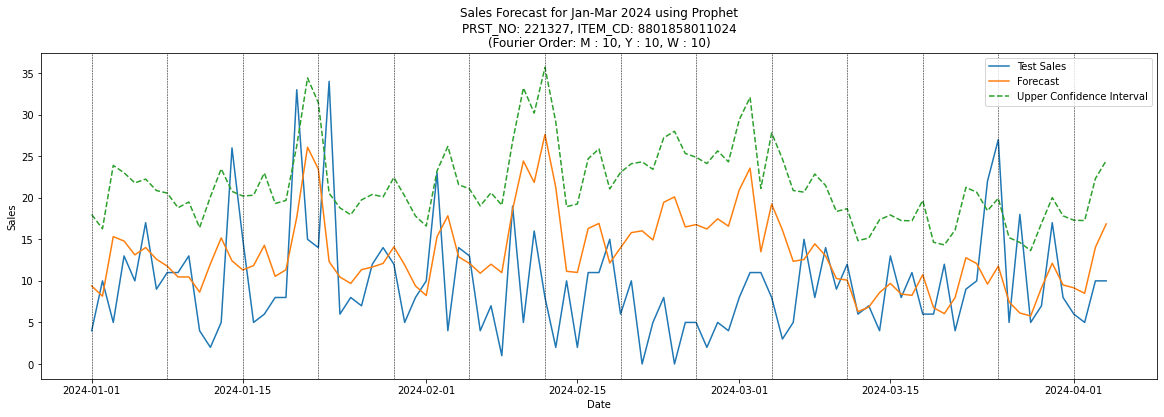

In [ ]:
plot_prophet_change(origin_df, 221327, 8801858011024, 10, 10, 10, holidays=holidays, changepoint=0.1)

17:08:33 - cmdstanpy - INFO - Chain [1] start processing
17:08:33 - cmdstanpy - INFO - Chain [1] done processing


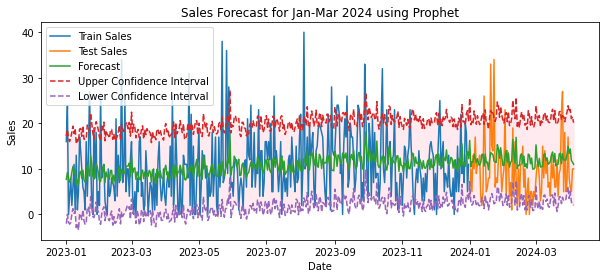

In [ ]:
plot_prophet(origin_df, 221327, 8801858011024)

In [ ]:
# PRST_NO별 ITEM_CD 기준으로 SALE_QTY를 합산
grouped_df = origin_df.groupby(['PRST_NO', 'ITEM_CD'])['SALE_QTY'].sum().reset_index()

# SALE_QTY 기준으로 내림차순 정렬 후 상위 10개 상품 선택
top_10_items = grouped_df.sort_values(by='SALE_QTY', ascending=False).head(10)

In [ ]:
top_10_items

,PRST_NO,ITEM_CD,SALE_QTY
3966,221327,8801858011024,4926
536,34984,8801858011024,4006
1908,122612,8801858011024,3526
3437,221327,88002798,2781
2594,151539,8801858011024,2758
4809,221915,88002798,2694
1777,122612,8801115134237,2676
5338,221915,8801858011024,2649
7,34984,88002798,2495
1379,122612,88002798,2465


17:08:33 - cmdstanpy - INFO - Chain [1] start processing
17:08:33 - cmdstanpy - INFO - Chain [1] done processing


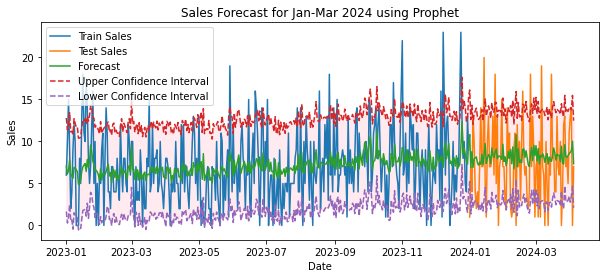

In [ ]:
# 카스캔
plot_prophet(origin_df, 122612, 8801858011024)

In [ ]:
store_ids = top_10_items['PRST_NO'].unique()
item_cds = top_10_items['ITEM_CD'].unique()

17:08:33 - cmdstanpy - INFO - Chain [1] start processing
17:08:34 - cmdstanpy - INFO - Chain [1] done processing


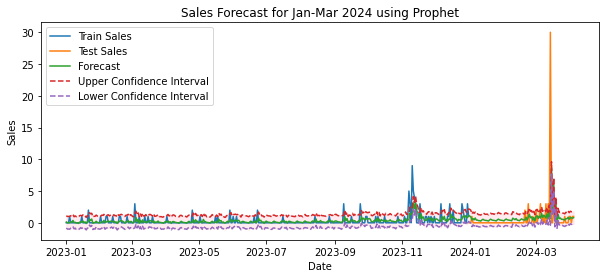

In [ ]:
# 빼빼로 아몬드
plot_prophet(origin_df, 221327, 8801062012725)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
def calculate_metrics(actual, predicted):
    # NRMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    nrmse = rmse / (actual.max() - actual.min())
    
    # NMAE
    mae = mean_absolute_error(actual, predicted)
    nmae = mae / actual.mean()
    
    # R-squared
    r2 = r2_score(actual, predicted)
    
    # MAPE
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    return nrmse, nmae, r2, mape



17:08:34 - cmdstanpy - INFO - Chain [1] start processing
17:08:34 - cmdstanpy - INFO - Chain [1] done processing


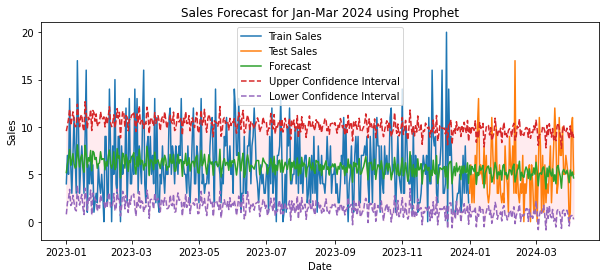

In [ ]:
plot_prophet(origin_df, 221327, 88002798)

17:08:34 - cmdstanpy - INFO - Chain [1] start processing
17:08:34 - cmdstanpy - INFO - Chain [1] done processing


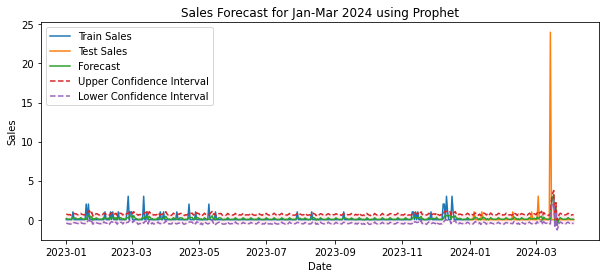

In [ ]:
# 빼빼로
plot_prophet(origin_df, 221327, 8801062012732)

## 체크

In [ ]:
# import pandas as pd
# import numpy as np
# from prophet import Prophet
# from sklearn.metrics import r2_score
# import matplotlib.pyplot as plt

# def plot_prophet_with_r2(origin_df: pd.DataFrame, prst_no: int, item_cd: int):
#     filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
#     filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
#     filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
#     if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
#         filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
#     if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
#         filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
#     train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
#     model = Prophet()
    
#     features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
#                 'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
#                 'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
#     for feature in features:
#         if feature in train_prophet.columns:
#             model.add_regressor(feature)
    
#     model.fit(train_prophet)
    
#     future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    
#     future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
#     future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
#     forecast = model.predict(future_with_features)
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(filtered_train['ds'], filtered_train['y'], label='Train Sales')
#     plt.plot(filtered_test['ds'], filtered_test['y'], label='Test Sales')
#     plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
#     plt.plot(forecast['ds'], forecast['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
#     plt.plot(forecast['ds'], forecast['yhat_lower'], label='Lower Confidence Interval', linestyle='--')
#     plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
#     plt.title('Sales Forecast for Jan-Mar 2024 using Prophet')
#     plt.xlabel('Date')
#     plt.ylabel('Sales')
#     plt.legend()
#     plt.show()
    
#     y_test = filtered_test['SALE_QTY'].values
#     y_pred = forecast['yhat'].values[:len(filtered_test)]
    
#     r2 = r2_score(y_test, y_pred)
#     print(f"R-squared (R²) value: {r2}")

#     return r2

# # Example usage
# # Assuming you have a DataFrame named `origin_df` with the necessary columns:
# # origin_df = pd.read_csv('your_data.csv')
# # plot_prophet_with_r2(origin_df, prst_no=123, item_cd=456)


17:08:35 - cmdstanpy - INFO - Chain [1] start processing
17:08:35 - cmdstanpy - INFO - Chain [1] done processing


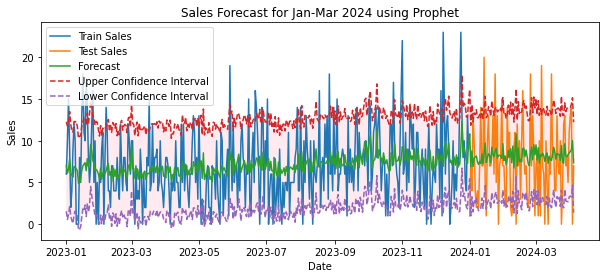

In [ ]:
# 카스캔
plot_prophet(origin_df, 122612, 8801858011024)

In [ ]:
# year_s = #
# week_s = #
# **kwargs

In [ ]:
def plot_prophet_test(origin_df: pd.DataFrame, prst_no: int, item_cd: int, month_s, year_s=10, week_s=10): 
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    # 모델 마개조 여기서 시작
    model = Prophet(weekly_seasonality=week_s, yearly_seasonality=year_s, daily_seasonality=False)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=month_s)
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)

    model.fit(train_prophet)
    
    # 예측 설정
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    
    # 미래 데이터프레임에 추가 특성들 포함
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    # 2024년도 데이터만 필터링
    filtered_test_2024 = filtered_test[filtered_test['YMD_CD'].dt.year == 2024]
    forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
    
    # 예측 결과와 실제 값 병합
    comparison_df = pd.merge(filtered_test_2024, forecast_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], left_on='YMD_CD', right_on='ds')
    
    # 범위 바깥에 있는 오차 절대값으로 계산
    out_of_bounds_error = 0
    for index, row in comparison_df.iterrows():
        if row['SALE_QTY'] > row['yhat_upper']:
            out_of_bounds_error += abs(row['SALE_QTY'] - row['yhat_upper'])
        elif row['SALE_QTY'] < row['yhat_lower']:
            out_of_bounds_error += abs(row['yhat_lower'] - row['SALE_QTY'])

    
    print('오차범위 바깥의 에러 합계 :', out_of_bounds_error)

    
    # 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_test_2024['YMD_CD'], filtered_test_2024['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Forecast')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_lower'], label='Lower Confidence Interval', linestyle='--')
    plt.fill_between(forecast_2024['ds'], forecast_2024['yhat_lower'], forecast_2024['yhat_upper'], color='pink', alpha=0.3)
    plt.title(f'Sales Forecast for Jan-Mar 2024 using Prophet\n(Fourier Order: M : {month_s}, Y : {year_s}, W : {week_s})')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

17:08:35 - cmdstanpy - INFO - Chain [1] start processing
17:08:35 - cmdstanpy - INFO - Chain [1] done processing


오차범위 바깥의 에러 합계 : 107.92092534711384


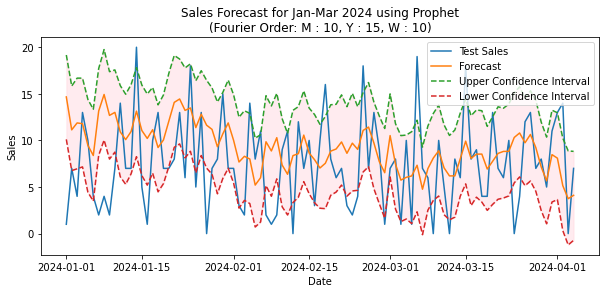

In [ ]:
plot_prophet_test(origin_df, 122612, 8801858011024, 10, 15, 10)

In [ ]:
# 루프로 파라메터 찾기
# for i in range(1, 30):
#     plot_prophet_test(origin_df, 122612, 88002798, i, 14, 23)

17:08:35 - cmdstanpy - INFO - Chain [1] start processing
17:08:36 - cmdstanpy - INFO - Chain [1] done processing


오차범위 바깥의 에러 합계 : 27.816408075431468


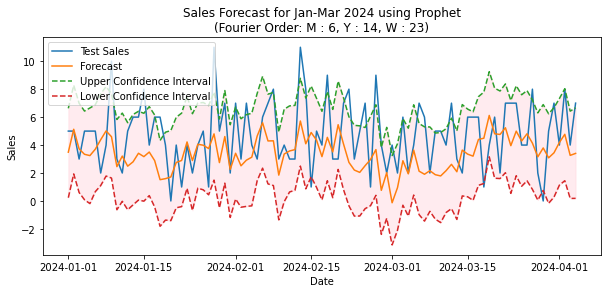

In [ ]:
plot_prophet_test(origin_df, 122612, 88002798, 6, 14, 23)

17:08:36 - cmdstanpy - INFO - Chain [1] start processing
17:08:36 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 2.70
MAE: 2.22
NMAE: 0.47
RMSE (Upper): 2.99
MAE (Upper): 2.39
NMAE (Upper): 0.50


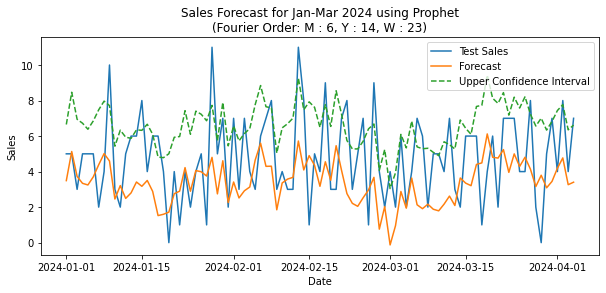

In [ ]:
plot_prophet_upper_only(origin_df, 122612, 88002798, 6, 14, 23)

In [ ]:
# 베스트 파라메터 찾기 함수
def find_best_params(origin_df, prst_no, item_cd, param_grid):
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
    
    best_params = None
    best_mae = float('inf')
    
    for params in all_params:
        model = Prophet(
            yearly_seasonality=params['yearly_seasonality'],
            weekly_seasonality=params['weekly_seasonality'],
            daily_seasonality=False
        )
        model.add_seasonality(name='monthly', period=30.5, fourier_order=params['monthly_seasonality'])
        
        features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                    'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                    'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
        
        for feature in features:
            if feature in train_prophet.columns:
                model.add_regressor(feature)
        
        model.fit(train_prophet)
        
        future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
        future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
        future_with_features = future_with_features.drop(columns=['YMD_CD'])
        
        forecast = model.predict(future_with_features)
        
        y_pred = forecast['yhat'].iloc[-len(filtered_test):].values
        y_true = filtered_test['SALE_QTY'].values
        
        mae = mean_absolute_error(y_true, y_pred)
        
        if mae < best_mae:
            best_mae = mae
            best_params = params
    
    return best_params, best_mae


17:08:36 - cmdstanpy - INFO - Chain [1] start processing
17:08:36 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 2.70
MAE: 2.22
NMAE: 0.47
RMSE (Upper): 2.97
MAE (Upper): 2.39
NMAE (Upper): 0.50


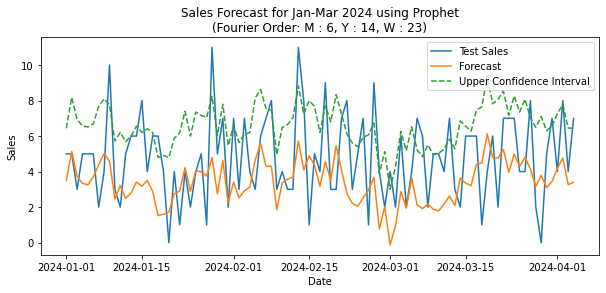

In [ ]:
plot_prophet_upper_only(origin_df, 122612, 88002798, 6, 14, 23)

In [ ]:
find_best_params(origin_df, 122612, 88002798, param_grid)

17:08:37 - cmdstanpy - INFO - Chain [1] start processing
17:08:37 - cmdstanpy - INFO - Chain [1] done processing
17:08:37 - cmdstanpy - INFO - Chain [1] start processing
17:08:37 - cmdstanpy - INFO - Chain [1] done processing
17:08:37 - cmdstanpy - INFO - Chain [1] start processing
17:08:37 - cmdstanpy - INFO - Chain [1] done processing
17:08:37 - cmdstanpy - INFO - Chain [1] start processing
17:08:38 - cmdstanpy - INFO - Chain [1] done processing
17:08:38 - cmdstanpy - INFO - Chain [1] start processing
17:08:38 - cmdstanpy - INFO - Chain [1] done processing
17:08:38 - cmdstanpy - INFO - Chain [1] start processing
17:08:38 - cmdstanpy - INFO - Chain [1] done processing
17:08:38 - cmdstanpy - INFO - Chain [1] start processing
17:08:38 - cmdstanpy - INFO - Chain [1] done processing
17:08:39 - cmdstanpy - INFO - Chain [1] start processing
17:08:39 - cmdstanpy - INFO - Chain [1] done processing


({'yearly_seasonality': 1, 'weekly_seasonality': 30, 'monthly_seasonality': 1},
 2.081761052482088)

In [ ]:
# 카스캔
find_best_params(origin_df, 122612, 8801858011024, param_grid)

17:08:39 - cmdstanpy - INFO - Chain [1] start processing
17:08:39 - cmdstanpy - INFO - Chain [1] done processing
17:08:39 - cmdstanpy - INFO - Chain [1] start processing
17:08:39 - cmdstanpy - INFO - Chain [1] done processing
17:08:39 - cmdstanpy - INFO - Chain [1] start processing
17:08:40 - cmdstanpy - INFO - Chain [1] done processing
17:08:40 - cmdstanpy - INFO - Chain [1] start processing
17:08:40 - cmdstanpy - INFO - Chain [1] done processing
17:08:40 - cmdstanpy - INFO - Chain [1] start processing
17:08:40 - cmdstanpy - INFO - Chain [1] done processing
17:08:40 - cmdstanpy - INFO - Chain [1] start processing
17:08:40 - cmdstanpy - INFO - Chain [1] done processing
17:08:41 - cmdstanpy - INFO - Chain [1] start processing
17:08:41 - cmdstanpy - INFO - Chain [1] done processing
17:08:41 - cmdstanpy - INFO - Chain [1] start processing
17:08:41 - cmdstanpy - INFO - Chain [1] done processing


({'yearly_seasonality': 1, 'weekly_seasonality': 30, 'monthly_seasonality': 1},
 3.915318780070397)

17:08:41 - cmdstanpy - INFO - Chain [1] start processing
17:08:41 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 5.48
MAE: 4.58
NMAE: 0.61
RMSE (Upper): 8.35
MAE (Upper): 7.05
NMAE (Upper): 0.94


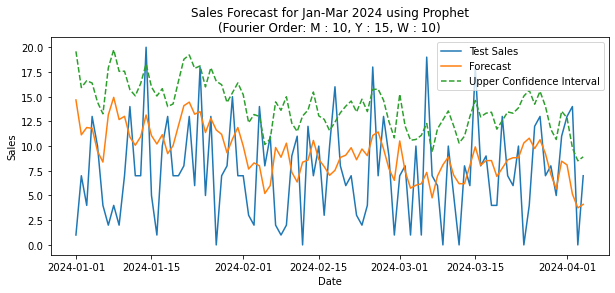

In [ ]:
plot_prophet_upper_only(origin_df, 122612, 8801858011024, 10, 15, 10)

In [ ]:
import matplotlib.pyplot as plt

def plot_prophet_upper_only(origin_df, prst_no, item_cd, month_s=10, year_s=10, week_s=10): 
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    model = Prophet(weekly_seasonality=week_s, yearly_seasonality=year_s, daily_seasonality=False)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=month_s)
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)

    model.fit(train_prophet)
    
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    filtered_test_2024 = filtered_test[filtered_test['YMD_CD'].dt.year == 2024]
    forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
    
    comparison_df = pd.merge(filtered_test_2024, forecast_2024[['ds', 'yhat', 'yhat_upper']], left_on='YMD_CD', right_on='ds')
    
    y_true = comparison_df['SALE_QTY']
    y_pred = comparison_df['yhat']
    y_upper = comparison_df['yhat_upper']
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nmae = mae / np.mean(y_true)
    
    rmse_upper = np.sqrt(mean_squared_error(y_true, y_upper))
    mae_upper = mean_absolute_error(y_true, y_upper)
    nmae_upper = mae_upper / np.mean(y_true)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'NMAE: {nmae:.2f}')
    
    print(f'RMSE (Upper): {rmse_upper:.2f}')
    print(f'MAE (Upper): {mae_upper:.2f}')
    print(f'NMAE (Upper): {nmae_upper:.2f}')
    
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_test_2024['YMD_CD'], filtered_test_2024['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Forecast')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    plt.fill_between(forecast_2024['ds'], forecast_2024['yhat_upper'], alpha=0.3, color='pink')
    plt.title(f'Sales Forecast for Jan-Mar 2024 using Prophet\n(Fourier Order: M : {month_s}, Y : {year_s}, W : {week_s})')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()


## 여기부터 이벤트 붙여서 시작

In [ ]:
def plot_prophet_event(origin_df, prst_no, item_cd, month_s=10, year_s=10, week_s=10): # 이벤트를 피처에 포함한 프로펫
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    model = Prophet(weekly_seasonality=week_s, yearly_seasonality=year_s, daily_seasonality=False)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=month_s)
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7', 'EVT_GIVE', 'EVT_DISCOUNT', 'EVT_PLUS', 'EVT_APP']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)

    model.fit(train_prophet)
    
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    filtered_test_2024 = filtered_test[filtered_test['YMD_CD'].dt.year == 2024]
    forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
    
    comparison_df = pd.merge(filtered_test_2024, forecast_2024[['ds', 'yhat', 'yhat_upper']], left_on='YMD_CD', right_on='ds')
    
    y_true = comparison_df['SALE_QTY']
    y_pred = comparison_df['yhat']
    y_upper = comparison_df['yhat_upper']
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nmae = mae / np.mean(y_true)
    
    rmse_upper = np.sqrt(mean_squared_error(y_true, y_upper))
    mae_upper = mean_absolute_error(y_true, y_upper)
    nmae_upper = mae_upper / np.mean(y_true)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'NMAE: {nmae:.2f}')
    
    print(f'RMSE (Upper): {rmse_upper:.2f}')
    print(f'MAE (Upper): {mae_upper:.2f}')
    print(f'NMAE (Upper): {nmae_upper:.2f}')
    
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_test_2024['YMD_CD'], filtered_test_2024['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Forecast')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    plt.title(f'Sales Forecast for Jan-Mar 2024 using Prophet\n(Fourier Order: M : {month_s}, Y : {year_s}, W : {week_s})')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

In [ ]:
def plot_prophet_holidays(origin_df, prst_no, item_cd, month_s=10, year_s=10, week_s=10, holidays=holidays): # 프로펫 홀리데이 파라메터 사용 함수
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    model = Prophet(weekly_seasonality=week_s, yearly_seasonality=year_s, daily_seasonality=False, holidays=holidays)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=month_s)
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7', 'EVT_GIVE', 'EVT_DISCOUNT', 'EVT_PLUS', 'EVT_APP']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)

    model.fit(train_prophet)
    
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    filtered_test_2024 = filtered_test[filtered_test['YMD_CD'].dt.year == 2024]
    forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
    
    comparison_df = pd.merge(filtered_test_2024, forecast_2024[['ds', 'yhat', 'yhat_upper']], left_on='YMD_CD', right_on='ds')
    
    y_true = comparison_df['SALE_QTY']
    y_pred = comparison_df['yhat']
    y_upper = comparison_df['yhat_upper']
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nmae = mae / np.mean(y_true)
    
    rmse_upper = np.sqrt(mean_squared_error(y_true, y_upper))
    mae_upper = mean_absolute_error(y_true, y_upper)
    nmae_upper = mae_upper / np.mean(y_true)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'NMAE: {nmae:.2f}')
    
    print(f'RMSE (Upper): {rmse_upper:.2f}')
    print(f'MAE (Upper): {mae_upper:.2f}')
    print(f'NMAE (Upper): {nmae_upper:.2f}')
    
    plt.figure(figsize=(20, 6))
    plt.plot(filtered_test_2024['YMD_CD'], filtered_test_2024['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Forecast')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    plt.title(f'Sales Forecast for Jan-Mar 2024 using Prophet\n(Fourier Order: M : {month_s}, Y : {year_s}, W : {week_s})')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

17:08:42 - cmdstanpy - INFO - Chain [1] start processing
17:08:42 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 5.48
MAE: 4.58
NMAE: 0.61
RMSE (Upper): 8.34
MAE (Upper): 7.06
NMAE (Upper): 0.94


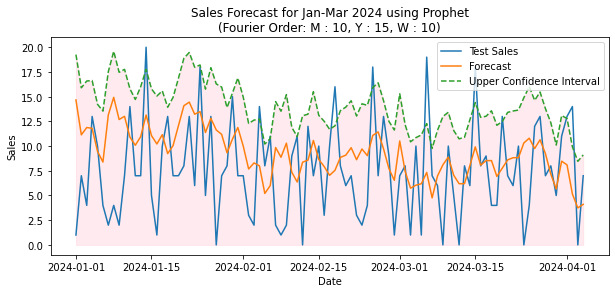

In [ ]:
plot_prophet_upper_only(origin_df, 122612, 8801858011024, 10, 15, 10)

17:09:35 - cmdstanpy - INFO - Chain [1] start processing
17:09:35 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 5.26
MAE: 4.30
NMAE: 0.57
RMSE (Upper): 6.69
MAE (Upper): 5.49
NMAE (Upper): 0.73


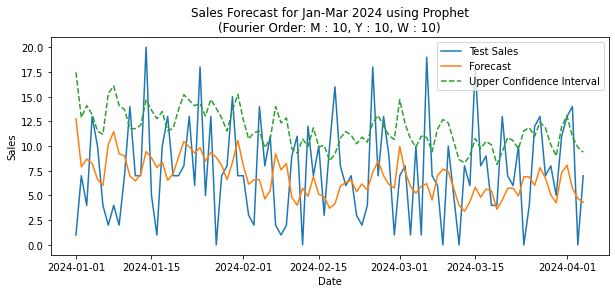

In [ ]:
plot_prophet_event(origin_df, 122612, 8801858011024, 10, 10, 10)

In [ ]:
promotion

,ITEM_CD,YMD_CD,EVT_GIVE,EVT_DISCOUNT,EVT_PLUS,EVT_APP
0,8801115381761,2022-12-04,0,0,2,0
1,8801115381761,2022-12-05,0,0,2,0
2,8801115381761,2022-12-06,0,0,2,0
3,8801115381761,2022-12-07,0,0,2,0
4,8801115381761,2022-12-08,0,0,2,0
...,...,...,...,...,...,...
305971,8801056233471,2024-03-31,0,0,0,0
305972,8801056233471,2024-04-01,0,2,0,0
305973,8801056233471,2024-04-02,0,2,0,0
305974,8801056233471,2024-04-03,0,2,0,0


In [14]:
origin_df.columns

Index(['YMD_CD', 'PRST_NO', 'ITEM_CD', 'SMCL_CD', 'SALE_QTY', 'SALE_QTY_lag_1',
       'SALE_QTY_lag_2', 'SALE_QTY_lag_3', 'SALE_QTY_lag_4', 'SALE_QTY_lag_5',
       'SALE_QTY_lag_6', 'SALE_QTY_lag_7', 'SALE_QTY_lag_14',
       'SALE_QTY_lag_21', 'SALE_QTY_lag_28', 'SALE_QTY_ma_2', 'SALE_QTY_ma_3',
       'SALE_QTY_ma_4', 'SALE_QTY_ma_5', 'SALE_QTY_ma_6', 'SALE_QTY_ma_7',
       'SALE_QTY_ma_14', 'SALE_QTY_ma_21', 'SALE_QTY_ma_28', 'SALE_QTY_std_2',
       'SALE_QTY_std_3', 'SALE_QTY_std_4', 'SALE_QTY_std_5', 'SALE_QTY_std_6',
       'SALE_QTY_std_7', 'SALE_QTY_std_14', 'SALE_QTY_std_21',
       'SALE_QTY_std_28', 'holidays', 'weekdays', 'fri', 'mon', 'sat', 'sun',
       'thu', 'tue', 'wed', 'week', 'before_holidays', 'ITEM_NM'],
      dtype='object')

In [15]:
def plot_prophet_mk2(origin_df, prst_no, item_cd, week_s=10, holidays=holidays): 
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    model = Prophet(weekly_seasonality=week_s, yearly_seasonality=True, daily_seasonality=False, holidays=holidays)
    
    features = ['YMD_CD', 'PRST_NO', 'ITEM_CD', 'SMCL_CD', 'SALE_QTY', 'SALE_QTY_lag_1',
       'SALE_QTY_lag_2', 'SALE_QTY_lag_3', 'SALE_QTY_lag_4', 'SALE_QTY_lag_5',
       'SALE_QTY_lag_6', 'SALE_QTY_lag_7', 'SALE_QTY_lag_14',
       'SALE_QTY_lag_21', 'SALE_QTY_lag_28', 'SALE_QTY_ma_2', 'SALE_QTY_ma_3',
       'SALE_QTY_ma_4', 'SALE_QTY_ma_5', 'SALE_QTY_ma_6', 'SALE_QTY_ma_7',
       'SALE_QTY_ma_14', 'SALE_QTY_ma_21', 'SALE_QTY_ma_28', 'SALE_QTY_std_2',
       'SALE_QTY_std_3', 'SALE_QTY_std_4', 'SALE_QTY_std_5', 'SALE_QTY_std_6',
       'SALE_QTY_std_7', 'SALE_QTY_std_14', 'SALE_QTY_std_21',
       'SALE_QTY_std_28', 'holidays', 'weekdays', 'fri', 'mon', 'sat', 'sun',
       'thu', 'tue', 'wed', 'week', 'before_holidays', 'ITEM_NM']
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)

    model.fit(train_prophet)
    
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    filtered_test_2024 = filtered_test[filtered_test['YMD_CD'].dt.year == 2024]
    forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
    
    comparison_df = pd.merge(filtered_test_2024, forecast_2024[['ds', 'yhat', 'yhat_upper']], left_on='YMD_CD', right_on='ds')
    
    y_true = comparison_df['SALE_QTY']
    y_pred = comparison_df['yhat']
    y_upper = comparison_df['yhat_upper']
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nmae = mae / np.mean(y_true)
    
    rmse_upper = np.sqrt(mean_squared_error(y_true, y_upper))
    mae_upper = mean_absolute_error(y_true, y_upper)
    nmae_upper = mae_upper / np.mean(y_true)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'NMAE: {nmae:.2f}')
    
    print(f'RMSE (Upper): {rmse_upper:.2f}')
    print(f'MAE (Upper): {mae_upper:.2f}')
    print(f'NMAE (Upper): {nmae_upper:.2f}')
    
    plt.figure(figsize=(20, 6))
    plt.plot(filtered_test_2024['YMD_CD'], filtered_test_2024['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Forecast')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    plt.title(f'Sales Forecast for Jan-Mar 2024 using Prophet\n(Fourier Order: M : {month_s}, Y : {year_s}, W : {week_s})')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

In [19]:
origin_df.rename(columns={'holidays':'holiday_flag'}, inplace=True)

In [17]:
def plot_prophet_mk3(origin_df, prst_no, item_cd, week_s=10): 
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    model = Prophet(weekly_seasonality=week_s, yearly_seasonality=True, daily_seasonality=False)
    
    features = ['YMD_CD', 'PRST_NO', 'ITEM_CD', 'SMCL_CD', 'SALE_QTY', 'SALE_QTY_lag_1',
       'SALE_QTY_lag_2', 'SALE_QTY_lag_3', 'SALE_QTY_lag_4', 'SALE_QTY_lag_5',
       'SALE_QTY_lag_6', 'SALE_QTY_lag_7', 'SALE_QTY_lag_14',
       'SALE_QTY_lag_21', 'SALE_QTY_lag_28', 'SALE_QTY_ma_2', 'SALE_QTY_ma_3',
       'SALE_QTY_ma_4', 'SALE_QTY_ma_5', 'SALE_QTY_ma_6', 'SALE_QTY_ma_7',
       'SALE_QTY_ma_14', 'SALE_QTY_ma_21', 'SALE_QTY_ma_28', 'SALE_QTY_std_2',
       'SALE_QTY_std_3', 'SALE_QTY_std_4', 'SALE_QTY_std_5', 'SALE_QTY_std_6',
       'SALE_QTY_std_7', 'SALE_QTY_std_14', 'SALE_QTY_std_21',
       'SALE_QTY_std_28', 'holidays', 'weekdays', 'fri', 'mon', 'sat', 'sun',
       'thu', 'tue', 'wed', 'week', 'before_holidays', 'ITEM_NM']
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)

    model.fit(train_prophet)
    
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    filtered_test_2024 = filtered_test[filtered_test['YMD_CD'].dt.year == 2024]
    forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
    
    comparison_df = pd.merge(filtered_test_2024, forecast_2024[['ds', 'yhat', 'yhat_upper']], left_on='YMD_CD', right_on='ds')
    
    y_true = comparison_df['SALE_QTY']
    y_pred = comparison_df['yhat']
    y_upper = comparison_df['yhat_upper']
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nmae = mae / np.mean(y_true)
    
    rmse_upper = np.sqrt(mean_squared_error(y_true, y_upper))
    mae_upper = mean_absolute_error(y_true, y_upper)
    nmae_upper = mae_upper / np.mean(y_true)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'NMAE: {nmae:.2f}')
    
    print(f'RMSE (Upper): {rmse_upper:.2f}')
    print(f'MAE (Upper): {mae_upper:.2f}')
    print(f'NMAE (Upper): {nmae_upper:.2f}')
    
    plt.figure(figsize=(20, 6))
    plt.plot(filtered_test_2024['YMD_CD'], filtered_test_2024['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Forecast')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    plt.title(f'Sales Forecast for Jan-Mar 2024 using Prophet\n(Fourier Order: M : {month_s}, Y : {year_s}, W : {week_s})')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

In [23]:
origin_df.drop(columns='ITEM_NM', inplace=True)

: 

In [21]:
plot_prophet_mk3(origin_df, 17687, 88002798)

ValueError: Unable to parse string "빙그레)바나나우유240ml" at position 0

In [ ]:
# 잔차 분산 계산 함수
def plot_prophet_jancha(origin_df: pd.DataFrame, prst_no: int, item_cd: int, month_s, year_s=10, week_s=10): 
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    if not isinstance(filtered_train['YMD_CD'], pd.DatetimeIndex):
        filtered_train['YMD_CD'] = pd.to_datetime(filtered_train['YMD_CD'])
    if not isinstance(filtered_test['YMD_CD'], pd.DatetimeIndex):
        filtered_test['YMD_CD'] = pd.to_datetime(filtered_test['YMD_CD'])
    
    train_prophet = filtered_train.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    # 모델 초기화 및 계절성 설정
    model = Prophet(weekly_seasonality=week_s, yearly_seasonality=year_s, daily_seasonality=False)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=month_s)
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
    for feature in features:
        if feature in train_prophet.columns:
            model.add_regressor(feature)

    model.fit(train_prophet)
    
    # 예측 설정
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    
    # 미래 데이터프레임에 추가 특성들 포함
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    future_with_features = future_with_features.drop(columns=['YMD_CD'])
    
    forecast = model.predict(future_with_features)
    
    # 2024년도 데이터만 필터링
    filtered_test_2024 = filtered_test[filtered_test['YMD_CD'].dt.year == 2024]
    forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
    
    # 예측 결과와 실제 값 병합
    comparison_df = pd.merge(filtered_test_2024, forecast_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], left_on='YMD_CD', right_on='ds')
    
    # 범위 바깥에 있는 오차 절대값으로 계산
    out_of_bounds_error = 0
    for index, row in comparison_df.iterrows():
        if row['SALE_QTY'] > row['yhat_upper']:
            out_of_bounds_error += abs(row['SALE_QTY'] - row['yhat_upper'])
        elif row['SALE_QTY'] < row['yhat_lower']:
            out_of_bounds_error += abs(row['yhat_lower'] - row['SALE_QTY'])
    
    # 잔차 계산 및 분산 출력
    comparison_df['residuals'] = comparison_df['SALE_QTY'] - comparison_df['yhat']
    residual_variance = np.var(comparison_df['residuals'])
    
    print('오차범위 바깥의 에러 합계 :', out_of_bounds_error)
    print('잔차의 분산:', residual_variance)
    
    # 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_test_2024['YMD_CD'], filtered_test_2024['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Forecast')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_upper'], label='Upper Confidence Interval', linestyle='--')
    plt.plot(forecast_2024['ds'], forecast_2024['yhat_lower'], label='Lower Confidence Interval', linestyle='--')
    plt.fill_between(forecast_2024['ds'], forecast_2024['yhat_lower'], forecast_2024['yhat_upper'], color='pink', alpha=0.3)
    plt.title(f'Sales Forecast for Jan-Mar 2024 using Prophet\n(Fourier Order: M : {month_s}, Y : {year_s}, W : {week_s})')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

17:09:48 - cmdstanpy - INFO - Chain [1] start processing
17:09:48 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 4.94
MAE: 3.91
NMAE: 0.52
RMSE (Upper): 7.10
MAE (Upper): 6.00
NMAE (Upper): 0.80


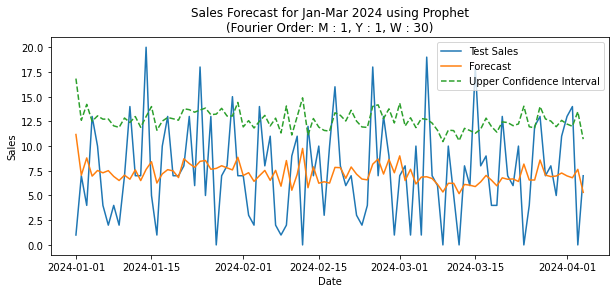

In [ ]:
plot_prophet_event(origin_df, 122612, 8801858011024, 1, 1, 30)

In [ ]:
origin_df['PRST_NO'].unique()

array([ 34984, 100944, 122612, 151539, 180098, 221327, 221522, 221915])

In [ ]:
plot_prophet_event(origin_df, 36646, 88002798, 1, 1, 30)

ValueError: Dataframe has less than 2 non-NaN rows.